# THE2 - CENG403 Spring 2024

This document contains the backbone structure for the take-home exam. You should complete this template for your solution.

# 1 The Gergen Library [THE1 Solution]

This section presents the code for solving THE1. You can modify any part as desired. The implementation of `rastgele_gercek`, `rastgele_dogal`, and `gergen` classes, as well as the necessary operations in the `Operation` class, are all provided.

## 1.1 Implementation for `rastgele_gercek` and `rastgele_dogal`

Uniform distribution is the only option available for `rastgele_dogal`. However, for `rastgele_gercek`, you can choose between uniform and gaussian distributions.

In [9]:
def cekirdek(sayi: int):
    #Sets the seed for random number generation
    random.seed(sayi)

def rastgele_dogal(boyut, aralik=None, dagilim='uniform'):
    """
    Generates data of specified dimensions with random integer values and returns a gergen object.

    Parameters:
    boyut (tuple): Shape of the desired data.
    aralik (tuple, optional): (min, max) specifying the range of random values. Defaults to None, which implies a default range.
    dagilim (string, optional): Distribution of random values ('uniform' or other types). Defaults to 'uniform'.

    Returns:
    gergen: A new gergen object with random integer values.
    """

    # Set a default range if aralik is not provided
    if aralik is None:
        aralik = (0, 10)

    def generate_random_data(shape):
        if len(shape) == 1:
            return [random_value(aralik, dagilim) for _ in range(shape[0])]
        else:
            return [generate_random_data(shape[1:]) for _ in range(shape[0])]

    def random_value(aralik, dagilim):
        if dagilim == 'uniform':
            return random.randint(*aralik)
        else:
            raise ValueError(f"Unsupported distribution: {dagilim}")

    data = generate_random_data(boyut)
    return gergen(data)

def rastgele_gercek(boyut, aralik=(0.0, 1.0), dagilim='uniform'):
    """
    Generates a gergen of specified dimensions with random floating-point values.

    Parameters:
    boyut (tuple): Shape of the desired gergen.
    aralik (tuple, optional): (min, max) specifying the range of random values. Defaults to (0.0, 1.0) for uniform distribution.
    dagilim (string, optional): Distribution of random value (e.g., 'uniform', 'gaussian'). Defaults to 'uniform'.

    Returns:
    gergen: A new gergen object with random floating-point values.
    """
    def generate_random_data(shape):
        if len(shape) == 1:
            return [random_value(aralik, dagilim) for _ in range(shape[0])]
        else:
            return [generate_random_data(shape[1:]) for _ in range(shape[0])]

    def random_value(aralik, dagilim):
        if dagilim == 'uniform':
            return random.uniform(*aralik)
        elif dagilim == 'gaussian':
            mean, std_dev = aralik
            return random.gauss(mean, std_dev)
        else:
            raise ValueError(f"Unsupported distribution: {dagilim}")

    data = generate_random_data(boyut)
    return gergen(data)



In [10]:
import math
from typing import Union
import matplotlib.pyplot as plt

## 1.2 Operation Class Definition

You can find the latest version of the Operation class here.

In [11]:
class Operation:
    def __call__(self, *operands, **kwargs):
        """
        Modified to accept keyword arguments as well.
        """
        self.operands = operands
        self.kwargs = kwargs  # Store keyword arguments separately
        self.outputs = None
        return self.ileri(*operands, **kwargs)

    def ileri(self, *operands, **kwargs):
        """
        Defines the forward pass of the operation.
        Must be implemented by subclasses to perform the actual operation.

        Parameters:
            *operands: Variable length operand list.
            **kwargs: Variable length keyword argument list.

        Raises:
            NotImplementedError: If not overridden in a subclass.
        """
        raise NotImplementedError

    def geri(self, grad_input):
        """
        Defines the backward pass of the operation.
        Must be implemented by subclasses to compute the gradients.

        Parameters:
            grad_input: The gradient of the loss w.r.t. the output of this operation.

        """
        raise NotImplementedError



## 1.3 Implemented Operations
The section contains all implementations from THE1. You can customize any part as you like, and you need to complete the `TODO` sections.


### 1.3.1 Add

In [12]:
class Add(Operation):
    def __init__(self) -> None:
        super().__init__()
        self.geri_sonuc = None
        self.ileri_sonuc = None
    def ileri(self, a, b):
        """
        Adds two gergen objects or a gergen object and a scalar.
        You can modify this function.
        """
        if isinstance(a, gergen) and isinstance(b, gergen):
            self.operands = [a, b]
            result = gergen(self.add_gergen(a.duzlestir().listeye(), b.duzlestir().listeye()), operation=self)
            result.boyutlandir(a.boyut())
        elif isinstance(a, gergen) and isinstance(b, (list)):
            self.operands = [a]
            result = gergen(self.add_list(a.listeye(), b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (list)):
            self.operands = [b]
            result = gergen(self.add_list(b.listeye(), a), operation=self)
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            self.operands = [a]
            result = gergen(self.add_scalar(a.listeye(), b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (int, float)):
            self.operands = [b]
            result = gergen(self.add_scalar(b.listeye(), a), operation=self)
        else:
            raise ValueError("Add operation requires at least one gergen operand.")

        return result

    def add_scalar(self, a, scalar):
        if isinstance(a, list):
            return [self.add_scalar(elem, scalar) for elem in a]
        else:
            return a + scalar

    def add_gergen(self, a, b):
        # Check if 'a' is a list
        if isinstance(a, list):
            # Check if 'b' is a list
            if isinstance(b, list):
                if len(a) != len(b):
                    raise ValueError("Dimensions of gergen objects do not match for addition.")
                return [a[i] + b[i] for i in range(len(a))]
            # If 'a' is a list and 'b' is a scalar
            elif not isinstance(b, list):
                return [item + b for item in a]

        # If 'a' is a scalar and 'b' is a list
        elif not isinstance(a, list) and isinstance(b, list):
            return [a + item for item in b]
        # Direct addition for scalars, or fallback error for unsupported types
        elif not isinstance(a, list) and not isinstance(b, list):
            return a + b

    def add_list(self, a, b):
        # Check if 'a' is a list
        if isinstance(a, list) and isinstance(b, list):
            return [self.add_list(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # If 'a' is list and b is scalar
        elif isinstance(a, list) and not isinstance(b, list):
            return [self.add_list(elem_a, b) for elem_a in a]
        elif not isinstance(a, list) and isinstance(b, list):
            return [self.add_list(a, elem_b) for elem_b in b]
        elif not isinstance(a, list) and not isinstance(b, list):
            return a + b

    def geri(self, grad_input):
        '''
        TODO: Implement the gradient computation for the Add operation.
        '''
        if(self.geri_sonuc is None):
            if isinstance(self.operands[0], gergen):
                boyut = self.operands[0].boyut()
                grad_a = rastgele_dogal(boyut, aralik =(1,1)) * grad_input
            if isinstance(self.operands[1], gergen):
                boyut = self.operands[1].boyut()
                grad_b = rastgele_dogal(boyut, aralik =(1,1)) * grad_input
            self.geri_sonuc = grad_a, grad_b
            
        return self.geri_sonuc
        


### 1.3.2 Sub

In [13]:
class Sub(Operation):
    """
    Subtracts two gergen objects or a gergen object and a scalar.
    You can modify this function.
    """
    def ileri(self, a, b):
        if isinstance(a, gergen) and isinstance(b, gergen):
            self.a, self.b = a, b
            self.operands = [a, b]
            result = gergen(self.subtract_gergen(a.duzlestir().veri, b.duzlestir().veri), operation=self)
            result.boyutlandir(a.boyut())
        elif isinstance(a, gergen) and isinstance(b, (list)):
            self.a = a
            self.operands = [a]
            result = gergen(self.subtract_list(a.veri, b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (list)):
            self.b = b
            self.operands = [b]
            result = gergen(self.subtract_list(a, b.veri), operation=self)
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            self.b = b
            self.operands = [a]
            result = gergen(self.subtract_scalar(a.veri, b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (int, float)):
            self.b = b
            self.operands = [b]
            result = gergen(self.subtract_scalar(b.veri, a), operation=self)
        else:
            raise ValueError("Sub operation requires at least one gergen operand.")
        return result

    def subtract_scalar(self, a, scalar):
        if isinstance(a, list):
            return [self.subtract_scalar(elem, scalar) for elem in a]
        else:
            return a - scalar

    def subtract_list(self, a, b):
        # Check if 'a' is a list
        if isinstance(a, list) and isinstance(b, list):
            return [self.subtract_list(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # If 'a' is list and b is scalar
        elif isinstance(a,list) and not isinstance(b, list):
            return [self.subtract_list(elem_a, b) for elem_a in a]
        elif not isinstance(a,list) and isinstance(b, list):
            return [self.subtract_list(a, elem_b) for elem_b in b]
        elif not isinstance(a, list) and not isinstance(b, list):
            return a - b

    def subtract_gergen(self, a, b):
        # Check if 'a' is a list
        if isinstance(a, list):
            # Check if 'b' is a list
            if isinstance(b, list):
                if len(a) != len(b):
                    raise ValueError("Dimensions of gergen objects do not match for subtraction.")
                return [a[i] - b[i] for i in range(len(a))]
            # If 'a' is a list and 'b' is a scalar
            elif not isinstance(b, list):
                return [item - b for item in a]

        # If 'a' is a scalar and 'b' is a list
        elif not isinstance(a, list) and isinstance(b, list):
            return [a - item for item in b]
        # Direct subtraction for scalars, or fallback error for unsupported types
        elif not isinstance(a, list) and not isinstance(b, list):
            return a - b

    def geri(self, grad_input):
        '''
        TODO: Implement the gradient computation for the Sub operation.
        '''
        if isinstance(self.operands[0], gergen):
            boyut = self.operands[0].boyut()
            grad_a = rastgele_dogal(boyut, aralik =(1,1)) * grad_input
        if isinstance(self.operands[1], gergen):
            boyut = self.operands[1].boyut()
            grad_b = rastgele_dogal(boyut, aralik =(-1,-1)) * grad_input
        
        return grad_a, grad_b
        

### 1.3.3 TrueDiv

In [14]:
class TrueDiv(Operation):
    """
    Divides two gergen objects or a gergen object and a scalar.
    You can modify this function.
    """
    def ileri(self, a, b):
        if isinstance(a, gergen) and isinstance(b, gergen):
            self.a, self.b = a, b
            self.operands = [a, b]
            result = gergen(self.divide_elements(a.duzlestir().veri, b.duzlestir().veri), operation=self)
            result.boyutlandir(a.boyut())
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            self.a = a
            self.operands = [a]
            result = gergen(self.divide_scalar(a.veri, b), operation=self)

        elif isinstance(b, gergen) and isinstance(a, (int, float)):
            # Division of a scalar by a gergen object is not typically defined,
            # but you can implement it based on your requirements.
            raise NotImplementedError("Division of a scalar by a gergen object is not implemented.")
        else:
            raise ValueError("TrueDiv operation requires at least one gergen operand.")

        return result

    def divide_scalar(self, a, scalar):
        if isinstance(a, list):
            return [self.divide_scalar(elem, scalar) for elem in a]
        else:
            if scalar == 0:
                raise ZeroDivisionError("Division by zero.")
            return a / scalar

    def divide_elements(self, a, b):
        # Both a and b are non-lists (scalars), perform direct division
        if not isinstance(a, list) and not isinstance(b, list):
            if b == 0:
                raise ZeroDivisionError("Division by zero.")
            return a / b
        # Both a and b are lists, perform element-wise division
        elif isinstance(a, list) and isinstance(b, list):
            if len(a) != len(b):
                raise ValueError("Dimensions of gergen objects do not match for division.")
            return [self.divide_elements(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # One of a or b is a list and the other is a scalar, divide each element of the list by the scalar
        elif isinstance(a, list):
            return [self.divide_elements(elem, b) for elem in a]
        else:
            raise NotImplementedError("Division of scalar by a list is not typically defined.")

    def geri(self, grad_input):
        '''
        TODO (Optional): Implement the gradient computation for the TrueDiv operation.
        '''
        pass



###1.3.4 Mul

In [15]:
class Mul(Operation):
    """
    Multiplies two gergen objects or a gergen object and a scalar.
    You can modify this function.
    """
    def ileri(self, a, b):

        if isinstance(a, gergen) and isinstance(b, gergen):
            self.a, self.b = a, b
            self.operands = [a, b]
            # a is a scalar gergen
            if a.uzunluk() == 1:
                result = gergen(self.multiply_scalar(b.veri,a.veri), operation= self)
            # b is a scalar gergen
            elif b.uzunluk() == 1:
                result = gergen(self.multiply_scalar(a.veri,b.veri), operation = self)
            else:
                result = gergen(self.multiply_elements(a.duzlestir().veri, b.duzlestir().veri), operation=self)
                result.boyutlandir(a.boyut())
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            self.a = a
            self.b = b
            self.operands = [a]
            result = gergen(self.multiply_scalar(a.veri, b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (int, float)):
            self.b = b
            self.b = a
            self.operands = [b]
            result = gergen(self.multiply_scalar(b.veri, a), operation=self)
        else:
            raise ValueError("Mul operation requires at least one gergen operand.")

        return result

    def multiply_scalar(self, a, scalar):
        if isinstance(a, list):
            return [self.multiply_scalar(elem, scalar) for elem in a]
        else:
            return a * scalar

    def multiply_elements(self, a, b):
        # Both a and b are non-lists (scalars), perform direct multiplication
        if not isinstance(a, list) and not isinstance(b, list):
            return a * b
        # Both a and b are lists, perform element-wise multiplication
        elif isinstance(a, list) and isinstance(b, list):
            if len(a) != len(b):
                raise ValueError("Dimensions of gergen objects do not match for multiplication.")
            return [self.multiply_elements(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # One of a or b is a list and the other is a scalar, multiply each element of the list by the scalar
        elif isinstance(a, list):
            return [self.multiply_elements(elem, b) for elem in a]
        else:
            return [self.multiply_elements(a, elem) for elem in b]

    def geri(self, grad_input):
        '''
        TODO: Implement the gradient computation for the Mul operation.
        '''
        return self.b * grad_input, self.a * grad_input


### 1.3.5 Us

In [16]:
class Us(Operation):
    """
    Power operation.
    You can modify this function.
    """

    def ileri(self, a, n):
        self.a = a
        self.n = n
        self.operands = [a]
        result = gergen(self.power_elements(a.veri, n), operation=self)
        self.ileri_sonuc = result
        return result

    def power_elements(self, a, n):

        if isinstance(a, list):
            return [self.power_elements(elem, n) for elem in a]
        else:
            return a ** n
    def multiply_elements(self, a, b):
        # Both a and b are non-lists (scalars), perform direct multiplication
        if not isinstance(a, list) and not isinstance(b, list):
            return a * b
        # Both a and b are lists, perform element-wise multiplication
        elif isinstance(a, list) and isinstance(b, list):
            if len(a) != len(b):
                raise ValueError("Dimensions of gergen objects do not match for multiplication.")
            return [self.multiply_elements(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # One of a or b is a list and the other is a scalar, multiply each element of the list by the scalar
        elif isinstance(a, list):
            return [self.multiply_elements(elem, b) for elem in a]
        else:
            return [self.multiply_elements(a, elem) for elem in b]

    def geri(self, grad_input):
        '''
        TODO: Implement the gradient computation for the Power operation.
        '''
        pass
        veri = self.a
        #print("veri: ", veri)
        n = self.n
        #print("n: ", n)
        return gergen(apply_elementwise(veri, lambda x: n * (x ** (n - 1)))) * grad_input

class Exp(Operation):
    """ Exponential operation."""
    def ileri(self, a):
        self.a = a
        self.operands = [a]
        result = gergen(self.exp_elements(a.veri), operation=self)
        return result

    def exp_elements(self, a):
        if isinstance(a, list):
            return [self.exp_elements(elem) for elem in a]
        else:
            return math.exp(a)

# print("---Us---")

# # gergen relu
# print("gergen")
# ones3 = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
# g1 = gergen([[1, 2, 3], [4, 5, 6], [7, 8, 9]], operation=Us(), requires_grad=True)
# us = Us()
# res = us.ileri(g1,2)
# print("result of gergen relu: \n", res)
# back = us.geri(gergen(ones3))
# print("gradient of the tensor: \n", back)

# print("#############################################")



### 1.3.6 Log10

In [ ]:
class Log10(Operation):
    """
    Log10 operation
    You can modify this function.
    """
    
    def ileri(self, a):
        self.a = a
        self.operands = [a]
        # Recursively check for non-positive values in the nested list structure
        if self.contains_non_positive(self.a.veri):
            raise ValueError("Logarithm undefined for non-positive values.")
        result = gergen(self.log_elements(a.veri), operation=self)
        return result

    def log_elements(self, a):
        # Recursively apply the base 10 logarithm to each element
        if isinstance(a, list):
            return [self.log_elements(elem) for elem in a]
        else:
            return math.log10(a)

    def contains_non_positive(self, a):
        # Recursively check for non-positive values and flatten the results
        def check_and_flatten(a):
            flag = False
            if isinstance(a, list):
                # Use a generator expression to recursively check each element and flatten the result
                for ele in a:
                    flag = check_and_flatten(ele)
            else:
                if a <=0:
                    return True
            return flag
        # Use 'any' on a flattened generator of boolean values
        return check_and_flatten(a)
    def multiply_elements(self, a, scalar):
        # Recursively multiply each element by the scalar
        if isinstance(a, list):
            return [self.multiply_elements(elem, scalar) for elem in a]
        else:
            return a * scalar

    def divide_elements(self, grad_output, b):
        # Recursively divide grad_output by b, assuming they have the same structure
        if isinstance(b, list):
            return [self.divide_elements(elem_grad, elem_b) for elem_grad, elem_b in zip(grad_output, b)]
        else:
            return grad_output / b

    def geri(self, grad_input):
        '''
        TODO (Optional): Implement the gradient computation for the Log10 operation.
        '''
        pass




### 1.3.7 Ln

In [17]:
class Ln(Operation):
    def ileri(self, a):
        """
        Implements the forward pass for the Ln operation.
        You can modify this function.
        """
        if not isinstance(a, gergen):
            raise ValueError("Ln operation requires a gergen operand.")
        self.a = a
        self.operands = [a]
        if self.contains_non_positive(self.a.listeye()):
            raise ValueError("Logarithm undefined for non-positive values.")

        result = gergen(self.log_elements(a.listeye()), operation=self)
        self.ileri_sonuc = result
        return result

    def log_elements(self, a):
        # Recursively apply the base 10 logarithm to each element
        if isinstance(a, list):
            return [self.log_elements(elem) for elem in a]
        else:
            return math.log(a) if a > 0 else math.log(a + 10**-4)

    def contains_non_positive(self, a):
        # Recursively check for non-positive values
        def check_and_flatten(a):
            if isinstance(a, list):
                return any(check_and_flatten(elem) for elem in a)
            else:
                if a <= 0:
                    a= 1
                    return True
                else:
                    return False
        # Use 'any' on a flattened generator of boolean values
        return check_and_flatten(a)

    def geri(self, grad_input):
        '''
        TODO: Implement the gradient computation for the Ln operation.
        '''

        return gergen(apply_elementwise(self.a, lambda x: 1/x)) * grad_input


# print("---Ln---")

# # gergen relu
# print("gergen")
# ones3 = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
# g1 = gergen([[1, 2, 3], [4, 5, 6], [7, 8, 9]], operation=Ln(), requires_grad=True)
# ln = Ln()
# res = ln.ileri(g1)
# print("result of gergen ln: \n", res)
# back = ln.geri(gergen(ones3))
# print("gradient of the tensor: \n", back)

# print("#############################################")


### 1.3.8 Sin, Cos, Tan

In [18]:
def apply_elementwise(g, func):
    """
    Applies a given function element-wise to the data in a gergen object.
    This version is capable of handling nested lists of any depth.
    """

    def recursive_apply(data):
        if isinstance(data, list):
            # Recursively apply func to each element if data is a list
            return [recursive_apply(sublist) for sublist in data]
        else:
            # Apply func directly if data is a scalar (non-list)
            return func(data)

    # Use the recursive function to apply the operation to the gergen object's data
    return recursive_apply(g.listeye())


class Sin(Operation):
    def ileri(self, a):
        """
        Implements the forward pass for the Sin operation.
        You can modify this function.
        """
        self.operands = [a]
        result = gergen(apply_elementwise(a, math.sin), operation=self)
        return result

    def geri(self, grad_output):
        """
        TODO(Optional): Implement the gradient computation for the Sin operation.
        """
        pass


class Cos(Operation):
    def ileri(self, a):
        """
        Implements the forward pass for the Cos operation.
        You can modify this function.
        """
        self.operands = [a]
        result = gergen(apply_elementwise(a, math.cos), operation=self)
        return result

    def geri(self, grad_output):
        """
        TODO(Optional): Implement the gradient computation for the Cos operation.
        """
        pass


class Tan(Operation):
    def ileri(self, a):
        """
        Implements the forward pass for the Tan operation.
        You can modify this function.
        """
        self.operands = [a]
        result = gergen(apply_elementwise(a, math.tan), operation=self)
        return result

    def geri(self, grad_output):
        """
        TODO(Optional): Implement the gradient computation for the Tan operation.
        """
        pass

### 1.3.9 Topla

In [19]:
class Topla(Operation):
    def ileri(self, a, eksen=None):
        """
        Forward pass for the Topla operation.
        You can modify this function.
        """

        def sum_elements(lst):
            if isinstance(lst[0], list):
                return [sum_elements(sublst) for sublst in zip(*lst)]
            else:
                return sum(lst)

        def sum_along_axis(data, axis):
            if axis == 0:
                return sum_elements(data)
            else:
                return [sum_along_axis(subdata, axis - 1) for subdata in data]
        self.operands = [a]
        if eksen is None:
            result = sum(a.duzlestir().listeye())
        elif isinstance(eksen, int):
            if eksen < 0 or eksen >= len(a.boyut()):
                raise ValueError("Axis out of bounds for gergen's dimensionality")
            result = sum_along_axis(a.listeye(), eksen)
        else:
            raise TypeError("Axis must be an integer or None")

        return gergen(result, operation=self)

    def geri(self, grad_input):
        """
        TODO(Optional): Implement the gradient computation for the Topla operation.
        """
        pass

### 1.3.10 Ortalama

In [20]:
class Ortalama(Operation):
    def ileri(self, a, eksen=None):
        """
        Forward pass for the Ortalama operation.
        """

        def average_elements(total_sum, total_elements):
            # Compute the average
            if isinstance(total_sum, list):
                # If total_sum is a list (multi-dimensional case), calculate the average for each sublist
                return [average_elements(ts, total_elements) for ts in total_sum]
            else:
                # For a single number, just divide
                return total_sum / total_elements
        self.operands = [a]
        sum_op = Topla()  # Instantiate the Sum operation

        total_sum = sum_op.ileri(a, eksen=eksen).listeye()

        if eksen is None:
            total_elements = a.uzunluk()
        else:
            if eksen < 0 or eksen >= len(a.boyut()):
                raise ValueError("Axis out of bounds for gergen's dimensionality")
            total_elements = a.boyut()[eksen]

        # Compute the average
        average_result = average_elements(total_sum, total_elements)

        return gergen(average_result, operation=self)

    def geri(self, grad_input):
        """
        TODO: Implement the gradient computation for the Ortalama operation.
        """
        # NOTE: I did not use Ortalama.geri in my implementation, so I did not implement it.
        pass


### 1.3.11 IcCarpim

In [62]:
class IcCarpim(Operation):
    geri_sonuc = None
    def ileri(self, a, b):
        self.a = a
        self.b = b
        self.operands = [a, b]
        if not isinstance(a, type(b)):
            raise ValueError("Both operands must be gergen objects.")

        def is_vector(v):
            return len(v.boyut()) == 1

        def is_matrix(m):
            return len(m.boyut()) == 2

        def vector_dot_product(v1, v2):
            if len(v1) != len(v2):
                raise ValueError("Vectors must have the same length for dot product.")
            return sum(x * y for x, y in zip(v1, v2))

        def matrix_multiply(m1, m2):
            if len(m1[0]) != len(m2):
                raise ValueError(
                    "The number of columns in the first matrix must match the number of rows in the second matrix.")
            self.ileri_sonuc = [[sum(a * b for a, b in zip(row_a, col_b)) for col_b in zip(*m2)] for row_a in m1]
            return self.ileri_sonuc

        if len(a.boyut()) > 2 or len(b.boyut()) > 2:
            raise ValueError("Operands must both be either 1-D vectors or 2-D matrices.")
        elif is_vector(a) and is_vector(b):
            # Perform vector dot product
            result = vector_dot_product(a.listeye(), b.listeye())
        elif is_matrix(a) and is_matrix(b):
            # Perform matrix multiplication
            result = matrix_multiply(a.listeye(), b.listeye())
        else:
            raise ValueError("Operands must both be either 1-D vectors or 2-D matrices.")

        # Return result
        return gergen(result, operation=self)

    def geri(self, grad_input):
        """
        TODO: Implement the gradient computation for the Ic_Carpim operation.
        """
        if self.geri_sonuc is None:

            self.geri_sonuc = [gergen(self.matrix_mul(grad_input.listeye(), self.b.devrik().listeye())), gergen(self.matrix_mul(self.a.devrik().listeye(), grad_input.listeye()))]
        return self.geri_sonuc
    
    def matrix_mul(self, a, b):
        return [[sum(a * b for a, b in zip(row_a, col_b)) for col_b in zip(*b)] for row_a in a]

### 1.3.12 DisCarpim

In [22]:
class DisCarpim(Operation):
    def ileri(self, a, b):
        """
        Computes the outer product of two gergen objects.
        """

        if not isinstance(a, gergen) or not isinstance(b, gergen):
            raise ValueError("Both operands must be gergen objects.")

        # Ensure the veri attributes are lists representing vectors
        if not all(isinstance(x, (int, float)) for x in a.listeye()) or not all(
                isinstance(y, (int, float)) for y in b.listeye()):
            raise ValueError("Both gergen objects must contain 1-D numerical data.")

        self.operands = [a,b]
        # Compute the outer product
        result = [[x * y for y in b.listeye()] for x in a.listeye()]

        # Return a new gergen object with the outer product as its veri
        return gergen(result, operation=self)

    def geri(self, grad_input):
        """
        TODO(Optional): Implement the gradient computation for the Dis_Carpim operation.
        """
        pass

### 1.3.13 Gergen Class

In [23]:
class gergen:

    #TODO: You should modify this class implementation

    __veri = None  # A nested list of numbers representing the data
    D = None  # Transpose of data
    turev = None  # Stores the derivate
    operation = None  # Stores the operation that produced the gergen
    __boyut = None  # Dimensions of the gergen (Shape)
    requires_grad = True  # Flag to determine if the gradient should be computed

    def __init__(self, veri=None, operation=None, requires_grad=None):
        # The constructor for the 'gergen' class.
        if veri is None:
            self.__veri = []
            self.__boyut = (0,)
            self.D = None
        else:
            self.__veri = veri
            self.__boyut = self.get_shape(veri, ())  # Assuming rectangular data
            self.D = None

    def __iter__(self):
        # The __iter__ method returns the iterator object itself.
        # You can reset the iterator here if you want to allow multiple passes over the data.
        pass

    def __next__(self):
        # The __next__ method should return the next value from the iterator.
        pass

    def __getitem__(self, key):
        """
        Allows for indexing or slicing the gergen object's data.

        Parameters:
        key (int, slice, tuple): An integer or slice for one-dimensional indexing,
                                    or a tuple for multi-dimensional indexing/slicing.

        Returns:
        The element or a new gergen object corresponding to the provided key.
        """

        # Helper function to handle recursive indexing/slicing
        def index_or_slice(data, key):
            if isinstance(key, int) or isinstance(key, slice):
                return data[key]
            elif isinstance(key, tuple):
                result = data
                for k in key:
                    result = index_or_slice(result, k)
                return result
            else:
                raise TypeError(f"Invalid index type: {type(key)}")

        # Perform the indexing or slicing operation
        result = index_or_slice(self.__veri, key)

        # If the result is a list, return it wrapped in a new gergen object
        return gergen(result)

    def __str__(self):
        # Generates a string representation
        if self.uzunluk() == 0:
            return "Empty Gergen"
        else:
            shape_str = ""
            for b in self.boyut():
                shape_str += str(b) + "x"
            if shape_str == "":
                shape_str += "0x"
            return shape_str[:-1] + " boyutlu gergen:" + "\n" + self.str_helper(self.listeye(), len(self.boyut()))

    @property
    def veri(self):
        return self.__veri

    def str_helper(self, data, shape, depth=0):
        if not shape:
            return str(data)
        elif not isinstance(data[0], list):
            return str(data)
        else:
            inner_results = []
            for subdata in data:
                inner_results.append(self.str_helper(subdata, shape, depth + 1))

            result = "[" + ("\n" * (shape - depth - 1)).join(r for r in inner_results) + "]"
            return result

    @staticmethod
    def get_shape(lst, shape=()):
        if not isinstance(lst, list):
            # base case
            return shape
        # peek ahead and assure all lists in the next depth
        # have the same length
        if isinstance(lst[0], list):
            l = len(lst[0])
            if not all(len(item) == l for item in lst):
                msg = 'not all lists have the same length'
                raise ValueError(msg)

        shape += (len(lst),)
        # recurse
        shape = gergen.get_shape(lst[0], shape)

        return shape

    @staticmethod
    def custom_zeros(shape):
        """
        Creates a multi-dimensional array of zeros with the specified shape.

        Parameters:
        shape (tuple): A tuple representing the dimensions of the array.

        Returns:
        A nested list (multi-dimensional array) filled with zeros.
        """
        if not shape:  # If shape is empty or reaches the end of recursion
            return 0
        # Recursively build nested lists
        return [gergen.custom_zeros(shape[1:]) for _ in range(shape[0])]

    # HELPER
    @staticmethod
    def prod(iterable):
        """Utility function to calculate the product of elements in an iterable."""
        result = 1
        for i in iterable:
            result *= i
        return result

    def __mul__(self, other: Union['gergen', int, float]) -> 'gergen':
        mul_operation = Mul()
        result_gergen = mul_operation(self, other)
        return result_gergen

    def __rmul__(self, other: Union['gergen', int, float]) -> 'gergen':
        mul_operation = Mul()
        result_gergen = mul_operation(self, other)
        return result_gergen

    def __truediv__(self, other: Union['gergen', int, float]) -> 'gergen':
        div_operation = TrueDiv()
        result_gergen = div_operation(self, other)
        return result_gergen

    def __rtruediv__(self, other: Union['gergen', int, float]) -> 'gergen':
        div_operation = TrueDiv()
        result_gergen = div_operation(self, other)
        return result_gergen

    def __add__(self, other):
        add_operation = Add()
        result_gergen = add_operation(self, other)
        return result_gergen

    def __radd__(self, other):
        add_operation = Add()
        result_gergen = add_operation(self, other)
        return result_gergen

    def __sub__(self, other):
        sub_operation = Sub()
        result_gergen = sub_operation(self, other)
        return result_gergen

    def __rsub__(self, other):
        sub_operation = Sub()
        result_gergen = sub_operation(other, self)
        return result_gergen

    def uzunluk(self):
        # Returns the total number of elements in the gergen
        total = 1
        for ele in self.__boyut:
            total *= ele
        return total

    def boyut(self):
        # Returns the shape of the gergen
        return self.__boyut

    def devrik(self):
        # Returns the transpose of gergen
        # Check if the gergen object is scalar
        if self.uzunluk() == 1:
            return gergen(self.__veri)
        # Check if the gergen object represents a 1D list (vector)
        if isinstance(self.__veri, list) and all(not isinstance(item, list) for item in self.__veri):
            # Convert each element into a list (column vector)
            return gergen([[item] for item in self.__veri])
        else:
            # Handle higher-dimensional cases (e.g., 2D matrices, 3D tensors, etc.)
            new_boyut = tuple(reversed(self.__boyut))
            order = list(reversed(range(len(self.__boyut))))
            arr = self.custom_zeros(new_boyut)  # Assuming custom_zeros initializes an array with the given shape
            paths = [0] * len(self.__boyut)
            while paths[0] < self.__boyut[0]:
                ref = self.listeye()
                place = arr
                for i in range(len(paths) - 1):
                    ref = ref[paths[i]]
                    place = place[paths[order[i]]]

                place[paths[order[-1]]] = ref[paths[-1]]
                paths[-1] += 1
                for i in range(len(paths) - 1, 0, -1):
                    if paths[i] >= self.__boyut[i]:
                        paths[i] = 0
                        paths[i - 1] += 1
                    else:
                        break
            self.D = gergen(arr)
            return gergen(arr)

    def L1(self):
        # Calculates and returns the L1 norm
        flattened_data = self.duzlestir().__veri  # Assuming flatten returns a gergen object

        # Calculate the L1 norm by summing the absolute values of elements in the flattened list
        l1_norm = sum(abs(item) for item in flattened_data)

        return l1_norm

    def L2(self):
        # Assuming flatten returns a gergen object and __veri holds the flattened data
        flattened_data = self.duzlestir().__veri

        # Calculate the L2 norm by summing the squares of elements in the flattened list and then taking the square root
        l2_norm = sum(item ** 2 for item in flattened_data) ** 0.5

        return l2_norm

    def Lp(self, p):
        # Calculates and returns the Lp norm, where p should be positive integer
        if p <= 0:
            raise ValueError("p must be a positive integer for Lp norm.")
        # Assuming flatten returns a gergen object and __veri holds the flattened data
        flattened_data = self.duzlestir().__veri

        # Calculate the Lp norm by raising elements to the power of p, summing, and then taking the p-th root
        lp_norm = sum(abs(item) ** p for item in flattened_data) ** (1 / p)

        return lp_norm

    def listeye(self):
        # Converts the gergen object into a list or a nested list, depending on its dimensions.
        if isinstance(self.__veri, list):
            if not self.__veri:
                return []
            return self.__veri.copy()
        else:
            return self.__veri

    def duzlestir(self):
        """Flattens a multidimensional list (self.__veri) into a 1D list."""
        if not isinstance(self.__veri, list):
            return gergen(self.__veri)
        flattened_list = []
        # Create a stack with the initial list
        stack = [self.__veri]

        # Process the stack
        while stack:
            current_item = stack.pop()
            if isinstance(current_item, list):
                # Extend the stack by reversing the current item list
                # to maintain the original order in the flattened list
                stack.extend(current_item[::-1])
            else:
                # If it's not a list, add it to the flattened list
                flattened_list.append(current_item)

        # Since we're appending elements to the end, but processing the stack in LIFO order,
        # we need to reverse the flattened list to restore the original element order
        flattened_list.reverse()

        # Create a new gergen instance with the flattened list
        return gergen(flattened_list)

    def boyutlandir(self, yeni_boyut):
        """Reshapes the gergen object to a new shape 'yeni_boyut', specified as a tuple."""
        # Flatten the data first
        flat_data = list(self.duzlestir().__veri)

        def reshape_helper(data, dims):
            if not dims:
                return data.pop(0)
            return [reshape_helper(data, dims[1:]) for _ in range(dims[0])]

        # Check if the new shape is compatible with the number of elements
        if self.prod(yeni_boyut) != len(flat_data):
            raise ValueError("New shape must have the same number of elements as the original.")

        # Use the helper to create the reshaped data and update the object's internal state
        self.__veri = reshape_helper(flat_data, yeni_boyut)
        self.__boyut = yeni_boyut

    def ic_carpim(self, other):
        ic_carpim_operation = IcCarpim()
        result_gergen = ic_carpim_operation(self, other)
        return result_gergen

    def dis_carpim(self, other):
        dis_carpim_operation = DisCarpim()
        result_gergen = dis_carpim_operation(self, other)
        return result_gergen

    def us(self, n):
        # Applies the power function to each element of the gergen object.
        power_operation = Us()
        result_gergen = power_operation(self, n)
        return result_gergen

    def exp(self):
        # Applies the exponential function to each element of the gergen object.
        exp_operation = Exp()
        result_gergen = exp_operation(self)
        return result_gergen
    def log(self):
        # Applies the log function to each element of the gergen object.
        log_operation = Log10()
        result_gergen = log_operation(self)
        return result_gergen

    def ln(self):
        # Applies the ln function to each element of the gergen object.
        log_operation = Ln()
        result_gergen = log_operation(self)
        return result_gergen

    def sin(self):
        # Applies the sin function to each element of the gergen object.
        sin_operation = Sin()
        result_gergen = sin_operation(self)
        return result_gergen

    def cos(self):
        # Applies the cos function to each element of the gergen object.
        cos_operation = Cos()
        result_gergen = cos_operation(self)
        return result_gergen

    def tan(self):
        # Applies the tan function to each element of the gergen object.
        tan_operation = Tan()
        result_gergen = tan_operation(self)
        return result_gergen

    def topla(self, eksen=None):
        # Calculates the sum of the elements of the gergen object, optionally along a specified axis 'eksen'.
        topla_operation = Topla()
        result_gergen = topla_operation(self, eksen=eksen)
        return result_gergen

    def ortalama(self, eksen=None):
        # Calculates the average of the elements of the gergen object, optionally along a specified axis 'eksen'.
        ortalama_operation = Ortalama()
        result = ortalama_operation(self, eksen=eksen)
        return result

    def turev_al(self, hidden_layer, output_layer, grad_output=1):
        """
        TODO: Implement the backward pass for the gergen object
        """
        #NOTE: I did not use gergen.turev_al in my implementation to calculate the gradients. Instead, I chose a different approach that stores the ileri and geri data in the opeations of
        # a 'Katman' object. More explanation is provided in the egit function.
        
        pass

# 2 The MLP Implementation

Now, you need to complete the MLP implementation. Your task is to complete the MLP implementation by following the steps outlined.

## 2.1 Katman Class

To complete MLP implementation, we first need to implement Katman (Layer) class. Implementing the Katman class involves defining its structure and operational methods such as the necessary mathematical operations, integrating activation functions, and setting up mechanisms for learning the layer's parameters during training.

In [24]:
class Katman:
    def __init__(self, input_size, output_size, activation=None):
        """
        TODO: Initialize weights and biases
        """
        self.weights = rastgele_gercek((input_size,output_size), dagilim = "gaussian") * math.sqrt(2 / input_size) # He initialization
        self.biases = rastgele_dogal((output_size,), aralik=(0, 0))
        # Set activation function
        
        # NOTE: the ileri data and geri data should be kept in these operations below
        self.activation = activation
        self.ic_carpim = IcCarpim()
        self.add = Add()

    def ileri(self, x):
        """
        TODO: Implement the forward pass
        """

        return self.activation.ileri(self.add.ileri(self.ic_carpim.ileri(x, self.weights), self.biases))

## 2.2 ReLU Operation

The `ReLU` class encapsulates the Rectified Linear Unit (ReLU) activation function. Characterized by the formula $f(x) = \max(0, x)$, the ReLU function modifies the input tensor by setting all its negative elements to zero while preserving the positive values.

The implementation of the `ReLU` class needs two principal methods:

1. **`ileri(self, x)`:** Termed `ileri` to denote the forward propagation phase, this method applies the ReLU function on an input tensor `x`.

2. **`geri(self, grad_input)`:** Labeled `geri`, indicating the backward propagation stage, this function is tasked with calculating the gradient of the ReLU function relative to the input tensor, given a gradient input `grad_input`.

In [25]:
class ReLU(Operation):
    def __init__(self):
        self.ileri_sonuc = None
        self.geri_sonuc = None
    def ileri(self, x):
        """
        TODO: ReLU activation function
        """
        self.ileri_sonuc = gergen(apply_elementwise(x, lambda x: max(0, x)))
        return self.ileri_sonuc

    def geri(self, grad_input):
        """
        TODO: Compute the gradient of the ReLU function
        """
        if(self.geri_sonuc is None):
            self.geri_sonuc = gergen(apply_elementwise(self.ileri_sonuc, lambda x: 1 if x > 0 else 0)) * grad_input
        return self.geri_sonuc
        


## 2.3 Softmax Operation

The `Softmax` class is designed to implement the Softmax activation function. The Softmax function converts the raw output scores from the model into probabilities by taking the exponential of each output and then normalizing these values by dividing by the sum of all the exponentials. This results in an output vector where each component represents the probability of the corresponding class, and the sum of all components is 1.

Implementing the `Softmax` class involves defining two key methods:

1. **`ileri(self, x)`:** This method, named `ileri` for the forward pass, applies the Softmax function to an input tensor `x`.

2. **`geri(self, grad_input)`:** The `geri` method, indicating the backward pass, is responsible for computing the gradient of the Softmax function with respect to the input tensor, given an input gradient `grad_input`.

In [26]:
class Softmax(Operation):
    def __init__(self):
        self.ileri_sonuc = None
        self.geri_sonuc = None
    def ileri(self, x):
        """
        TODO: Softmax activation function
        """
        veri = x.listeye()
        result = []
        sum_exp = x.exp().topla().listeye()
        for i in veri:
            if not isinstance(i, list):
                result.append(math.exp(i) / sum_exp)
            else:
                result.append(self.ileri(gergen(i)).listeye())
        self.ileri_sonuc = gergen(result)      
        return self.ileri_sonuc

    
    def geri(self, y_true):
        """
        TODO: Compute the gradient of the Softmax function
        
        """
        # NOTE: This is actually not "geri" of softmax. It is the gradient of the loss function with respect to the input of softmax. I chose to implement it this way since it is more practical.
        if (self.geri_sonuc is None):
            self.geri_sonuc = (self.ileri_sonuc - y_true);
        return self.geri_sonuc

        


## 2.4 MLP Class

The `MLP` class is a template for creating our custom MLP.

When setting up (`__init__`), you need to define:
- `input_size`: The shape of input layer.
- `hidden_size`: The shape of the hidden layer.
- `output_size`: How many outputs you need at the end, like how many categories you're classifying.

The main job of this setup is to prepare the layers with their settings and connections.

The `ileri` method takes your data (`x`) and sends it through all the layers.

In [27]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        """
        TODO: Initialize the MLP with input, hidden, and output layers
        """
        self.hidden_layer = Katman(input_size,hidden_size, activation=ReLU())
        self.output_layer = Katman(hidden_size, output_size, activation=Softmax())

    def ileri(self, x):
        """
        TODO: Implement the forward pass
        """
        self.ileri_sonuc = self.output_layer.ileri(self.hidden_layer.ileri(x))
        return self.ileri_sonuc


## 2.5 Cross-Entropy Loss



In [81]:

def cross_entropy(y_pred, y_true):
    """
    TODO: Implement the cross-entropy loss function
    y_pred : Predicted probabilities for each class in each sample
    y_true : True labels.
    Remember, in a multi-class classification context, y_true is typically represented in a one-hot encoded format.
    """
    veri_pred = y_pred.listeye()[0]
    veri_true = y_true.listeye()[0]
    n = len(veri_pred)
    for i in range(len(veri_pred)):
            if veri_true[i] == 1:
                return -math.log(veri_pred[i],math.e)/n



## 2.6 Implementing the training pipeline with `egit()`

The `egit()` function adjusts the model's weights and biases to decrease errors and improve predictions through epochs. Here's a simplified overview of its components and steps:

### Main Components:

- **`mlp`**: The MLP model that we implemented.
- **`inputs`**: The data fed into the model.
- **`targets`**: The labels for each input
- **`epochs`**: The number of complete passes through the training dataset.
- **`learning_rate`**: How much the model's weights are adjusted during training to minimize error.

You need to implement these training steps:

1. **Forward Pass**

2. **Calculate Loss**

3. **Backward Pass**

4. **Update Parameters**

5. **Reset Gradients**

6. **Loss Reporting**


In [107]:
def egit(mlp, inputs, targets, epochs, learning_rate):
    """
    TODO: Implement the training loop
    """
    loss_history = []
    for epoch in range(epochs):
        '''
        TODO: Implement training pipeline for each example
        '''
        # Forward pass - wtih mlp.ileri
        
        # Calculate Loss - with cross_entropy
        loss = 0
        for (input, target) in zip(inputs, targets):
            loss += cross_entropy(mlp.ileri(gergen(input)), gergen(target))

            # Backward pass - Compute gradients for example

            #NOTE: Here I make the necessary gradient computations by tracing the operations in the 'Katman' class.
            # Once computed, the gradients are stored in the operations of the 'Katman' class. This way, I can avoid making redundant computations for the same example.
            grad_w1 = mlp.hidden_layer.ic_carpim.geri(
                                                    mlp.hidden_layer.add.geri(
                                                        mlp.hidden_layer.activation.geri(
                                                            mlp.output_layer.ic_carpim.geri(
                                                                mlp.output_layer.add.geri(
                                                                    mlp.output_layer.activation.geri(
                                                                        target))[0])[0]))[0])[1]
            grad_b1 = mlp.hidden_layer.add.geri(
                                                mlp.hidden_layer.activation.geri(
                                                    mlp.output_layer.ic_carpim.geri(
                                                        mlp.output_layer.add.geri(
                                                            mlp.output_layer.activation.geri(
                                                                target))[0])[0]))[1]
            
            grad_w2 = mlp.output_layer.ic_carpim.geri(
                                                        mlp.output_layer.add.geri(
                                                            mlp.output_layer.activation.geri(
                                                                target))[0])[1]
            grad_b2 = mlp.output_layer.add.geri(
                                                mlp.output_layer.activation.geri(
                                                    target))[1]
            # Update parameters
            mlp.hidden_layer.weights -= learning_rate * grad_w1
            mlp.hidden_layer.biases -= learning_rate * grad_b1
            mlp.output_layer.weights -= learning_rate * grad_w2
            mlp.output_layer.biases -= learning_rate * grad_b2
            # Reset gradients
            mlp.hidden_layer.activation.geri_sonuc = None
            mlp.hidden_layer.ic_carpim.geri_sonuc = None
            mlp.hidden_layer.add.geri_sonuc = None
            mlp.output_layer.activation.geri_sonuc = None
            mlp.output_layer.ic_carpim.geri_sonuc = None
            mlp.output_layer.add.geri_sonuc = None
            # Print epoch loss here if desired

        average_loss = loss / len(inputs)
        loss_history.append(average_loss)
        print("Epoch: {}, Loss: {}".format(epoch, average_loss))


    return mlp, loss_history

## 2.7 Implementing the testing pipeline with `test()`

The `test()` measures the trained model's performance in test data.

### Main Components:

- **`mlp`**: The model that we trained with egit().
- **`inputs`**: Testing data.
- **`targets`**: Labels for testing data.


In [108]:
def test(mlp, test_inputs, test_targets):
    """
    TODO: Implement the testing pipeline
    """
    def find_max_index(lst):
        max = lst[0]
        index = 0
        for i in range(1, len(lst)):
            if lst[i] > max:
                max = lst[i]
                index = i
        return index

    score = 0
    loss = 0
    for (input, target) in zip(test_inputs, test_targets):
        output = mlp.ileri(gergen(input))
        
        loss += cross_entropy(output, gergen(target))
        #print("Output: ", len(target[0]))
        predicted_value = find_max_index(output.listeye()[0]) +1
        true_value = find_max_index(target[0]) + 1
        #print("Predicted value: ", predicted_value)
        #print("True value: ", true_value)
        if (predicted_value == true_value):
            score += 1

    accuracy = score * (100 / len(test_inputs))
    print(f"Accuracy: {accuracy} % ")
    
    loss = loss / len(test_inputs)
    print("Average Loss: ", loss)

    
    # Calculate loss (assuming cross-entropy loss)
    
    
    return loss

## 2.8 Data Handling Process

In [85]:
import pandas as pd
import io
from sklearn.preprocessing import LabelBinarizer
def data_preprocessing(data_file):
    # Load the data
    data = pd.read_csv(data_file, header=None)
    # Extract labels from the first column
    labels = data.iloc[:, 0]  # Assuming the labels are in the first column
    # Apply LabelBinarizer to the labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    # Get the remaining columns as data
    data = data.iloc[:, 1:] * (1/255)
    data = data.values.tolist()
    data = [[elem] for elem in data]
    labels = labels.tolist()
    labels = [[elem] for elem in labels]
    # Return the data and labels
    
    return data, labels

# data, labels = data_preprocessing("train_data.csv")
# print(labels[0])


## 2.9 Training and Testing our custom MLP

Epoch: 0, Loss: 0.1694645027670497
Epoch: 1, Loss: 0.09859543399861989
Epoch: 2, Loss: 0.07197348909588919
Epoch: 3, Loss: 0.05883981410889313
Epoch: 4, Loss: 0.05093697300654268
Epoch: 5, Loss: 0.04557032589974411
Epoch: 6, Loss: 0.04161845485165027
Epoch: 7, Loss: 0.03858723332429227
Epoch: 8, Loss: 0.03618202396758964
Epoch: 9, Loss: 0.03422691819047059
Accuracy: 88.86 % 
Average Loss:  0.03974600781458826


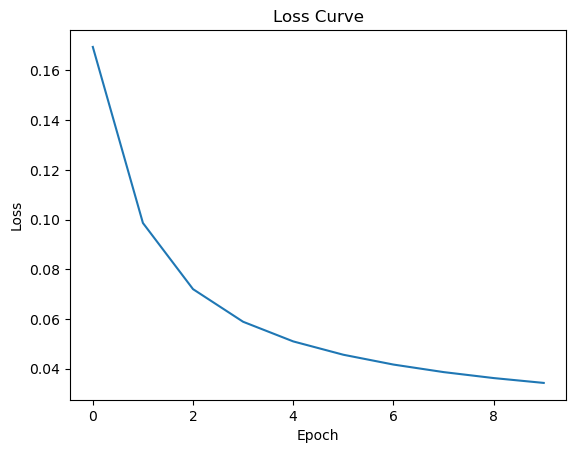

In [154]:
'''
TODO: Implement the training pipeline.
'''

# Load the data
train_data_path = "./train_data.csv"
test_data_path = "./test_data.csv"
data, labels = data_preprocessing(train_data_path)


test_data, test_labels = data_preprocessing(test_data_path)
# Initialize the MLP with input, hidden, and output layers
input_size = 28*28
hidden_size = 10
output_size = 10
mlp = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Train the MLP using your preferred training loop
epochs = 10
learning_rate = 0.001
training_size = 3000
trained_mlp, loss_history = egit(mlp, data[:training_size], labels[:training_size], epochs, learning_rate)
test_loss = test(trained_mlp, test_data, test_labels)

plot_Loss(loss_history)
#NOTE: Accuracy would be much higher if all of the training size was used. Overall, loss keeps decreasing as the epochs increase, which is a good sign.

## 2.10 The Loss Curve

One of the first things we should do when analyzing a model is to plot the loss curve. We should ideally see a smoothly decreasing curve over iterations/epochs.

In [87]:
import matplotlib.pyplot as plt
def plot_Loss(loss_history):
    '''
    TODO: Plot the Loss Curve Using loss_history
    '''
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.show()


## 2.11 Find the Best Hyperparameters

Let us train the model for different values for our hyperparameters.

In [112]:
learning_rates = [1e-2, 1e-3, 1e-4,1e-5]
hidden_layer_sizes = [5,10,30]

# results is dictionary mapping tuples of the form
# (learning_rate, hidden_layer_size) to tuples of the form
# (training_loss, test_loss).
results = {}
best_loss = 10   # The lowest test loss that we have seen so far.
best_model = None # The MLP object that achieved the lowest test loss.
best_lr = None  # The learning rate for the best model
best_hl = None  # The hidden layer size for the best model
epochs = 10
training_size = 100
for lr in learning_rates:
  for hl in hidden_layer_sizes:

    ## @TODO: Create a new MLP instance
    mlp = MLP(input_size=input_size, hidden_size=hl, output_size=output_size)
    ## @TODO: Create a new loss instance with cross-entropy
    
    ## @TODO: Train with the training set with current lr and hl for 10 epochs
    model, loss_history = egit(mlp, data[:training_size], labels[:training_size], epochs, lr)

    # @TODO: Predict values for test set and calculate test loss
    test_loss = test(model, test_data, test_labels)
    train_loss = loss_history[-1]
    print(f"learning rate={lr} and hidden layer size={hl} provided train_loss={train_loss:.3f} and test_loss={test_loss:.3f}")

    # Save the results
    results[(lr,hl)] = (train_loss, test_loss)
    if test_loss < best_loss:
        best_lr = lr
        best_hl = hl
        best_loss = test_loss
        best_model = model

print(f'\nLowest test loss achieved: {best_loss} with params hl={best_hl} and lr={best_lr}')


# NOTE: The accuracy is low beacuse of the small training size. I sadly did not have time to use the whole training set.


Epoch: 0, Loss: 0.21684379716820473
Epoch: 1, Loss: 0.18638556354238622
Epoch: 2, Loss: 0.16502306769306607
Epoch: 3, Loss: 0.14552661470147366
Epoch: 4, Loss: 0.12899112458250536
Epoch: 5, Loss: 0.11544275827702714
Epoch: 6, Loss: 0.10496142495497689
Epoch: 7, Loss: 0.09579584148482695
Epoch: 8, Loss: 0.08821287715767973
Epoch: 9, Loss: 0.0820320382581404
Accuracy: 48.370000000000005 % 
Average Loss:  0.15209118312667477
learning rate=0.01 and hidden layer size=5 provided train_loss=0.082 and test_loss=0.152
Epoch: 0, Loss: 0.21806563638895315
Epoch: 1, Loss: 0.18509021464018577
Epoch: 2, Loss: 0.1536541661848099
Epoch: 3, Loss: 0.13289225338996785
Epoch: 4, Loss: 0.11601666282293946
Epoch: 5, Loss: 0.09989763617129985
Epoch: 6, Loss: 0.08717757902170828
Epoch: 7, Loss: 0.0738384110446607
Epoch: 8, Loss: 0.06315596187410902
Epoch: 9, Loss: 0.05398981056936959
Accuracy: 63.51 % 
Average Loss:  0.12037012482051118
learning rate=0.01 and hidden layer size=10 provided train_loss=0.054 and

## 2.12 Plot the Loss Curve of the Best Model

Let us analyze some aspects of the best model. To keep things short, let us just plot the loss history.

In [ ]:
'''
TODO: Plot the Loss Curve for the best model using loss_history
'''

# Plot the loss curve for the best model
# NOTE: loss curve the best model trained over a larger training set is in 2.9

# 3 Implementation in PyTorch

Now, you need to implement the same MLP structure using PyTorch library.

## 3.1 MLP_torch class

In [155]:
'''
TODO: PyTorch implementation
'''

import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_torch, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x


##3.2 Data Preprocessing

In [156]:
'''
TODO: Handle the data and labels for PyTorch
'''
import torch
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

def data_preprocessing_torch(data_file):
    # Load the data
    data = pd.read_csv(data_file)
    
    labels = data.iloc[:, 0]
    label_binarizer = LabelBinarizer()
    labels = label_binarizer.fit_transform(labels)
    labels = torch.tensor(labels, dtype=torch.float32)  # Convert labels to PyTorch tensor
    
    data = data.iloc[:, 1:] * (1/255)
    data = torch.tensor(data.values, dtype=torch.float32)  # Convert data to PyTorch tensor
    
    return data, labels

## 3.3 Training Pipeline

In [157]:
'''
TODO: Implement the training pipeline using PyTorch
'''
import torch
import torch.nn as nn
import torch.optim as optim

def train_torch(mlp, inputs, targets, epochs, learning_rate):
    # Define the loss function (CrossEntropyLoss) and optimizer (e.g., SGD or Adam)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mlp.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        epoch_loss = 0.0

        # Training loop for each example
        for input_data, target in zip(inputs, targets):
            # Convert inputs and targets to PyTorch tensors

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output = mlp.forward(input_data)

            # Calculate loss
            loss = criterion(output, target)

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            # Accumulate the loss for the epoch
            epoch_loss += loss.item()

        # Calculate average epoch loss
        epoch_loss /= len(inputs)

        # Print epoch loss
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}')

    return mlp



##3.4 Testing Pipeline

In [158]:
'''
TODO: Implement the testing pipeline using PyTorch
'''
import torch
import torch.optim as optim

def test_torch(mlp, inputs, targets):
    # Define the loss function (e.g., CrossEntropyLoss for classification)
    criterion = nn.CrossEntropyLoss()
    
    # Set the model to evaluation mode
    mlp.eval()
    
    # Convert inputs and targets to PyTorch tensors
    
    # Forward pass
    outputs = mlp(inputs)
    
    # Calculate the loss
    loss = criterion(outputs, targets)
    
    print(f'Test Loss: {loss.item()}')

    return loss.item()


## 3.5 Main code for PyTorch implementation

In [159]:
'''
TODO: Train and test the PyTorch model
'''

# Load the data
data, labels = data_preprocessing_torch("./train_data.csv")
test_data, test_labels = data_preprocessing_torch("./test_data.csv")
# Initialize the MLP with input, hidden, and output layers
input_size = data.shape[1]
hidden_size = 10
output_size = 10
mlp = MLP_torch(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Train the MLP using PyTorch

epochs = 10
learning_rate = 0.001

trained_torch_mlp = train_torch(mlp, data, labels, epochs, learning_rate)
test_torch(trained_torch_mlp,test_data, test_labels)



c:\Users\subas\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH: 0, Loss: 2.23690228933954
EPOCH: 1, Loss: 2.0052381265735058
EPOCH: 2, Loss: 1.8944358895007263
EPOCH: 3, Loss: 1.7823220067003012
EPOCH: 4, Loss: 1.7453257249792764
EPOCH: 5, Loss: 1.7305953270662153
EPOCH: 6, Loss: 1.7222579458223723
EPOCH: 7, Loss: 1.7166336543011995
EPOCH: 8, Loss: 1.712439735458281
EPOCH: 9, Loss: 1.709109250697692
Test Loss: 1.7083741426467896


1.7083741426467896